# WEIGHT INITIALIZATION

Xavier Glorot and Yoshua Bengio analized different weight initialization techniques in their paper from 2010:  
<i>[1] "Understanding the difficulty of training deep feedforward neural networks"</i>. 

In 2016 Kaiming He, Xiangyu Zhang, Shaoqing Ren and Jian Sun derive an initialization specifically for ReLU neurons in their paper:  
<i>[2] "Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification"</i>.

We do not know what the final value of every weight should be in the trained network, but it is reasonable to assume that approximately half of the weights will be positive and half of them will be negative. A reasonable-sounding idea then might be to set all the initial weights to zero, which we expect to be the "best guess" in expectation. This turns out to be a mistake, because if every neuron in the network cumputes the same output, then they will also all compute the same gradients during backpropagation and undergo the exact same parameter updates. There is no source of assimetry between the neurons if their weights are initialized to be the same.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../")

from src.fc_net import NeuralNetwork
from src.layers import tanh_forward, relu_forward

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

# plot configuration
%matplotlib inline
plt.rcParams["figure.figsize"] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

<b>Small random numbers</b>. We still want the weights to be very close to zero, but not identically zero. As a solution it is common to initialize the weights to small number drawn from a zero mean, unit standard deviation gaussian distribution.

$$ W = epsi * np.random.randn(W.shape) $$

However, it is not necessarily the case that smaller numbers will work strictly better. A nerual network that has very small weights will during backpropagation compute very small gradients and this could diminish the gradient signal flow.

One problem with the suggestion of using weights drawn at random is that the distribution of the outputs has a variance that grows with the number of inputs. Consider the inner product $ y = \sum_{i}^{n} w_{i}x_{i} $, which gives the raw activation of a neuron before the non-linearity. Assuming the data and the weights are centered (have zero mean), and that all $ w_{i}$ , $ x_{i} $ are independent and identically distributed, the variance of $ y $ is:

$$ \displaystyle
\begin{align*}
& Var(y) = Var(\sum_{i}^{n} w_{i}x_{i}) = \sum_{i}^{n} Var(w_{i}x_{i}) = \\
& = \sum_{i}^{n} [E(w_{i})]^{2}Var(x_{i}) + [E(x_{i})]^{2}Var(w_{i}) + Var(x_{i})Var(w_{i})= \\
& = \sum_{i}^{n} Var(x_{i})Var(w_{i}) = nVar(w)Var(x) \\
\end{align*}
$$

![Weight Init](img/nn_weight_init.png "Weight Init")

In [2]:
# Initialize random Gaussian data.
np.random.seed(0)
input_dim = 1000
hidden_dims = [500, 1500, 2500, 1500, 500, 200]
# hidden_dims = [1000, 1000, 1000, 1000, 1000, 1000]
num_classes = 10
X_toy = np.random.randn(input_dim) * 0.25

Layer outputs after forward pass:


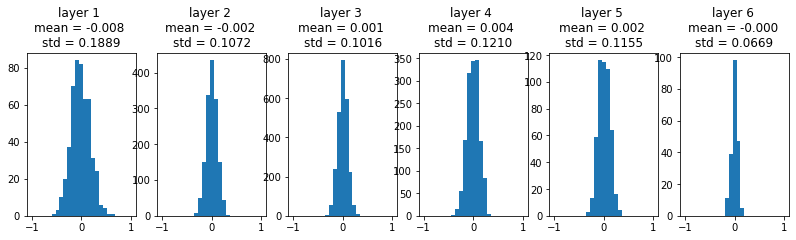

In [3]:
# Initializing a network with small random weights.
nn_model = NeuralNetwork(hidden_dims, input_dim, num_classes,
                         weight_scale=0.025,
                         nonlinearity="tanh")

# Run a forward pass.
layers = {}
layers["0"] = X_toy
for i in range(len(hidden_dims)):
    layers["%d" % (i+1)], _= tanh_forward(layers["%d" % (i)].dot(nn_model.params["W%d" % (i+1)]))

# Plot the activations.
print("Layer outputs after forward pass:")
plt.subplots(figsize=(16.0, 3.0))
for i in range(len(hidden_dims)):
    mean = np.mean(layers["%d" % (i + 1)])
    std = np.std(layers["%d" % (i + 1)])
    plt.subplot(1, len(hidden_dims) + 1, i + 1)
    plt.hist(layers["%d" % (i + 1)], bins=25, range=(-1, 1))
    plt.title("layer %d \nmean = %.3f \nstd = %.4f" % (i + 1, mean, std))
plt.show()

<b>Variance calibration</b>. From the derivation above it follows that we can normalize the variance of each neuron's output to be the same as the variance of its input $ x $. We just have to make sure that the variance of every weight $ w $ is $ \frac{1}{n} $.

Let $ \vec{s^{l}} $ be the vector of activations of layer $ l $. Again, let us assume the inputs and the weights are centered, and that all $ w_{i}^{k} $ , $ s_{i}^{k} $ are independant and identically distributed.  
Additionally, assume that we are using a symmetric activation function $ f $ with unit derivative at 0 (i.e. $ f'(0) = 1 $), and that we are in the linear regime of the function.

Consider the activation of a neuron from layer $ l $.

$$ \displaystyle s^{l} = f(y^{l-1}) = f \left( \sum_{j=1}^{n_{l-1}} s_{j}^{l-1} w_{j}^{l-1} \right) $$

For the variance of $ s^{l} $ we have:

$$ \displaystyle Var(s^{l}) = Var(\sum_{j=1}^{n_{l-1}} s_{j}^{l-1} w_{j}^{l-1})
= n_{l-1} Var(s^{l-1}) Var(w^{l-1}) = \cdots
= Var(x) \prod_{i=1}^{l-1} n_{i}Var(w^{i}) $$

Now, in order to normalize the variance of the output of each neuron in every layer we must have:

$$ \displaystyle n_{i} Var(w^{i}) = 1  \implies Var(w^{i}) = \frac{1}{n_{i}} $$

Next, let us consider the gradient of the loss with respect to the activattion of a neuron from layer $ l $:

$$ \displaystyle
\begin{align*}
& \frac{\partial L}{\partial s^{l}}
= \sum_{j=1}^{n_{l+1}} \frac{\partial L}{\partial s_{j}^{l+1}} \frac{\partial s_{j}^{l+1}}{\partial s^{l}}
= \sum_{j=1}^{n_{l+1}} \frac{\partial L}{\partial s_{j}^{l+1}} \frac{s_{j}^{l+1}}{y^{l}} \frac{y^{l}}{s^{l}}
= \sum_{j=1}^{n_{l+1}} \frac{\partial L}{\partial s_{j}^{l+1}} \frac{df(y^{l})}{dy^{l}} \frac{ \sum_{k=1}^{n_{l}} s_{k}^{l} w_{k}^{l}}{ds^{l}}
= \sum_{j=1}^{n_{l+1}} \frac{\partial L}{\partial s_{j}^{l + 1}} w_{j}^{l} \\
& Var \left( \frac{\partial L}{\partial s^{l}} \right)
= Var \left( \sum_{j=1}^{n_{l+1}} \frac{\partial L}{\partial s_{j}^{l + 1}} w_{j}^{l} \right)
= Var \left( \frac{\partial L}{\partial s^{l + 1}} \right) n_{l+1} Var(w^{l}) \\
& Var \left( \frac{\partial L}{\partial s^{1}} \right)
= Var \left( \frac{\partial L}{\partial s^{l}} \right) \prod_{i=1}^{l} n_{i+1} Var(w^{i})
\end{align*} $$

The variance of the back-propagated gradient might vanish or explode as we consider deeper networks. Thus, we must have:

$$ \displaystyle n_{i+1} Var(w^{i}) = 1  \implies Var(w^{i}) = \frac{1}{n_{i+1}} $$

As a compromise between these two constraints, we have:

$$ \displaystyle Var(w^{i}) = \frac{2}{n_{i} + n_{i + 1}} $$

Thus, the following initialization, known as <i>"Xavier initialization"</i>, is proposed when drawing from a Gaussian distribution:

$$ \displaystyle W \sim \mathcal{N} \left( 0, \sqrt{ \frac{2}{n_{i} + n_{i + 1}}} \right) $$

When drawning from a uniform distribution we have the following:

$$ \displaystyle
\begin{align*}
& W \sim \mathcal{U} \left[ - A, A \right] \\
& Var(W) = \frac{1}{12}(A - (-A))^{2} \\
& \frac{2}{n_{i} + n_{i + 1}} = \frac{A^{2}}{3} \\
& A = \sqrt{\frac{6}{n_{i} + n_{i + 1}}} \\
& W \sim \mathcal{U} \left[ - \sqrt{ \frac{6}{n_{i} + n_{i + 1}}}, \sqrt{ \frac{6}{n_{i} + n_{i + 1}}} \right] \\
\end{align*}
$$

![Weight Init Xavier](img/nn_weight_init_xavier.png "Weight Init Xavier")

Layer outputs after Xavier initialization:


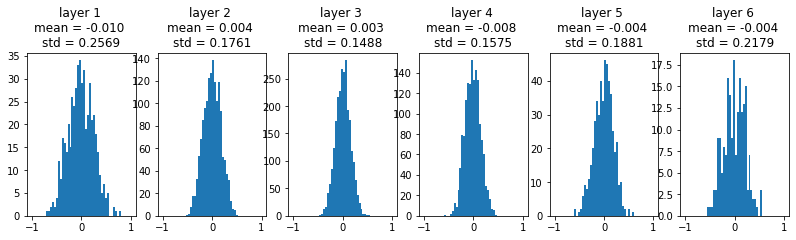

In [4]:
# Initializing a network with small random weights.
nn_model = NeuralNetwork(hidden_dims, input_dim, num_classes,
                         weight_scale="Xavier",
                         nonlinearity="tanh")

# Run a forward pass.
layers = {}
layers["0"] = X_toy
for i in range(len(hidden_dims)):
    layers["%d" % (i+1)], _= tanh_forward(layers["%d" % (i)].dot(nn_model.params["W%d" % (i+1)]))

# Plot the activations.
print("Layer outputs after Xavier initialization:")
plt.subplots(figsize=(16.0, 3.0))
for i in range(len(hidden_dims)):
    mean = np.mean(layers["%d" % (i + 1)])
    std = np.std(layers["%d" % (i + 1)])
    plt.subplot(1, len(hidden_dims) + 1, i + 1)
    plt.hist(layers["%d" % (i + 1)], bins=50, range=(-1, 1))
    plt.title("layer %d \nmean = %.3f \nstd = %.4f" % (i + 1, mean, std))
plt.show()

<b>Initialization for Rectifiers</b>. <i>"Xavier"</i> initialization is based on the assumption that the activation function is symmetric and it works in the linear regime for small values. However, this assumpstions are invalid when working with ReLU activation functions.

Let us again consider the raw activation of a neuron from layer $ l $ before the non-linearity. We can assume that the weights are centered (have zero mean), and that all $ w_{i}^{k}$ , $ s_{i}^{k} $ are independant and identically distributed. However, now the inputs are not centered. The variance of $ y^{l} $ is:

$$ \displaystyle
\begin{align*}
& Var(y^{l}) = Var \left( \sum_{j=1}^{n_{l-1}} w_{j}^{l-1}s_{j}^{l-1} \right)
= \sum_{j=1}^{n_{l-1}} Var(w_{j}^{l-1}s_{j}^{l-1}) = \\
& = \sum_{j=1}^{n_{l-1}} E((w_{j}^{l-1})^{2}) E((s_{j}^{l-1})^{2})
= \sum_{j=1}^{n_{l-1}} \left( Var(w_{j}^{l-1}) + [E(w_{j}^{l-1})]^{2} \right) E((s_{j}^{l-1})^{2}) \\
& = \sum_{j}^{n_{l-1}} Var(w_{i}^{l-1}) E((s_{i}^{l-1})^{2})
= n_{l-1} Var(w^{l-1}) E((s^{l-1})^{2}) \\
\end{align*}
$$

For the ReLU activation we have $ s^{l-1} = max(0, y^{l-1}) $, and since the weights are zero-centered, then $ y^{l-1} $ is zero-centered. This leads to $ \displaystyle E[(s^{l-1})^{2}] = \frac{1}{2} Var(y^{l-1}) $. And thus, we obtain:

$$ \displaystyle Var(y^{l}) = \frac{1}{2} n_{l-1} Var(w^{l-1}) Var(y^{l-1}) = \cdots = Var(x) \prod_{i=1}^{n_{l-1}} \frac{1}{2} n_{i}Var(w^{i}) $$

Now, in order to normalize the variance of the raw activation of each neuron in every layer we must have:

$$ \displaystyle \frac{1}{2} n_{i} Var(w^{i}) = 1  \implies Var(w^{i}) = \frac{2}{n_{i}} $$

Next, let us consider the gradient of the loss with respect to the activattion of a neuron from layer $ l $:

$$ \displaystyle
\frac{\partial L}{\partial s^{l}}
= \sum_{j=1}^{n_{l+1}} \frac{\partial L}{\partial s_{j}^{l+1}} \frac{\partial s_{j}^{l+1}}{\partial s^{l}}
= \sum_{j=1}^{n_{l+1}} \frac{\partial L}{\partial s_{j}^{l+1}} \frac{s_{j}^{l+1}}{y^{l}} \frac{y^{l}}{s^{l}}
= \sum_{j=1}^{n_{l+1}} \frac{\partial L}{\partial s_{j}^{l+1}} \frac{df(y^{l})}{dy^{l}} \frac{ \sum_{k=1}^{n_{l}} s_{k}^{l} w_{k}^{l}}{ds^{l}}
= \sum_{j=1}^{n_{l+1}} \frac{\partial L}{\partial s_{j}^{l + 1}} \frac{df(y^{l})}{dy^{l}} w_{j}^{l} $$

The derivative of $ f $ for the ReLU case is exactly zero or one, and their probabilities are equal. Thus:

$$ \displaystyle
\begin{align*}
& E \left[ \frac{df(y^{l})}{dy^{l}} \right] = \frac{1}{2} \\
& Var \left[ \frac{df(y^{l})}{dy^{l}} \right] = \frac{1}{4} \\
\end{align*}
$$  


$$ \displaystyle
\begin{align*}
& Var \left( \frac{\partial L}{\partial s^{l}} \right)
= Var \left( \sum_{j=1}^{n_{l+1}} \frac{\partial L}{\partial s_{j}^{l + 1}} \frac{df(y^{l})}{dy^{l}} w_{j}^{l} \right)
= n_{l+1} Var \left( \frac{\partial L}{\partial s^{l + 1}} \frac{df(y^{l})}{dy^{l}} w^{l} \right) \\
& = n_{l+1} \left( Var \left( \frac{\partial L}{\partial s^{l + 1}} \frac{df(y^{l})}{dy^{l}} \right) + \underbrace{E \left[ \frac{\partial L}{\partial s^{l + 1}} \frac{df(y^{l})}{dy^{l}} \right]^{2}}_{0} \right) \left( Var(w^{l}) + \underbrace{E[w^{l}]^{2}}_{0} \right) \\
& = n_{l+1} \left( Var \left( \frac{\partial L}{\partial s^{l + 1}} \right) + \underbrace{E \left[ \frac{\partial L}{\partial s^{l + 1}} \right]^{2}}_{0} \right) \left( \underbrace{Var \left( \frac{df(y^{l})}{dy^{l}} \right)}_{\frac{1}{4}} + \underbrace{E \left[ \frac{df(y^{l})}{dy^{l}} \right]^{2}}_{\frac{1}{4}} \right) Var(w^{l}) \\
& = Var \left( \frac{\partial L}{\partial s^{l + 1}} \right) \frac{1}{2} n_{l+1} Var(w^{l}) \\
& Var \left( \frac{\partial L}{\partial s^{1}} \right)
= Var \left( \frac{\partial L}{\partial s^{l}} \right) \prod_{i=1}^{l} n_{i+1} Var(w^{i})
\end{align*}
$$

Thus, again for deeper networks we must have:

$$ \displaystyle \frac{1}{2} n_{i+1} Var(w^{i}) = 1  \implies Var(w^{i}) = \frac{2}{n_{i+1}} $$

Again, as in the previous case we could make a compromise between the two constraints. However, the authors of [3] note that it is sufficient to use either of the constraints. Namely, if the initialization properly scales the forward signal, then this means that the backward signal is also scaled properly; and vice versa.

![Weight Init ReLU](img/nn_weight_init_relu.png "Weight Init ReLU")

<b>Initializing the biases</b>. It is possible to initialize the biases to be zero, since  the assimetry breaking is provided by the weights. For ReLU non-linearities, some people like to use small constant value such as 0.01 for all biases because this ensures that all ReLU units fire in the beginning. It is not clear if this provides a consistent improvement and it is more common to simply use 0 bias initialization.

Layer outputs after Xavier initialization:


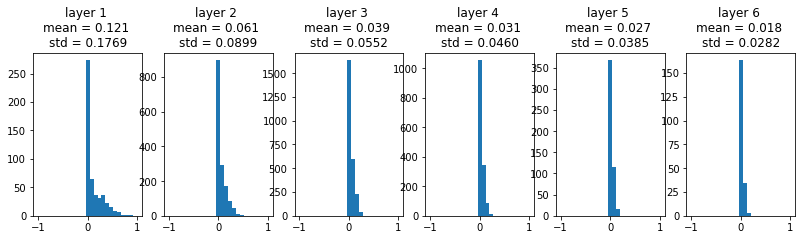

In [5]:
# Initializing a network with small random weights.
nn_model = NeuralNetwork(hidden_dims, input_dim, num_classes,
                         weight_scale="Xavier",
                         nonlinearity="relu")

# Run a forward pass.
layers = {}
layers["0"] = X_toy
for i in range(len(hidden_dims)):
    layers["%d" % (i+1)], _= relu_forward(layers["%d" % (i)].dot(nn_model.params["W%d" % (i+1)]))

# Plot the activations.
print("Layer outputs after Xavier initialization:")
plt.subplots(figsize=(16.0, 3.0))
for i in range(len(hidden_dims)):
    mean = np.mean(layers["%d" % (i + 1)])
    std = np.std(layers["%d" % (i + 1)])
    plt.subplot(1, len(hidden_dims) + 1, i + 1)
    plt.hist(layers["%d" % (i + 1)], bins=25, range=(-1, 1))
    plt.title("layer %d \nmean = %.3f \nstd = %.4f" % (i + 1, mean, std))
plt.show()

Layer outputs after Kaiming initialization:


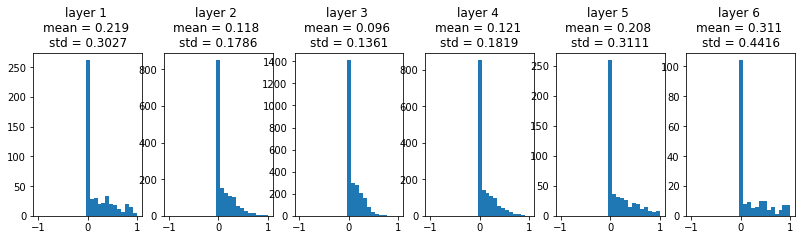

In [6]:
# Initializing a network with small random weights.
nn_model = NeuralNetwork(hidden_dims, input_dim, num_classes,
                         weight_scale="Kaiming",
                         nonlinearity="relu")

# Run a forward pass.
layers = {}
layers["0"] = X_toy
for i in range(len(hidden_dims)):
    layers["%d" % (i+1)], _= relu_forward(layers["%d" % (i)].dot(nn_model.params["W%d" % (i+1)]))

# Plot the activations.
print("Layer outputs after Kaiming initialization:")
plt.subplots(figsize=(16.0, 3.0))
for i in range(len(hidden_dims)):
    mean = np.mean(layers["%d" % (i + 1)])
    std = np.std(layers["%d" % (i + 1)])
    plt.subplot(1, len(hidden_dims) + 1, i + 1)
    plt.hist(layers["%d" % (i + 1)], bins=25, range=(-1, 1))
    plt.title("layer %d \nmean = %.3f \nstd = %.4f" % (i + 1, mean, std))
plt.show()